In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from scipy.integrate import quad

In [2]:
def τ(w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    return np.log((x * (1-y)) / ((1-x) * y)) / np.log(w_j / w_i)


def T(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, PLOT_N=False, PLOT_δ=False):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - 2*((w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - 2*((w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - 2*((w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
    p_anmt_eumt = 1 - (1 - 2*((w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here...

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # 
    τ_euwt_eumt = τ(w_euwt, w_eumt, x=0.95, y=1/N)
    # start with one or delta*N individuals
    τ_euwt_anwt = τ(w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # 
    τ_anwt_anmt = τ(w_anwt, w_anmt, x=1-1/N, y=1/N)
     # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ(w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        1/p_min 
        + 1/p_anwt_anmt 
        + 1/p_anmt_eumt 
        + τ_euwt_anwt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    
    if PLOT_N:
        plt.plot(N, 1/p_min, label='T_min', color='blue')
        plt.plot(N, 1/p_anwt_anmt, label='T_anwt_anmt', color='orange' )
        plt.plot(N, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(N, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(N, τ_anwt_anmt, '--', label='τ_anwt_anmt', color='red')
        plt.plot(N, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
        
    if PLOT_δ:
        plt.plot(δ, 1/p_min, label='T_min', color='blue')
        plt.plot(δ, [1/p_anwt_anmt for d in δ], label='T_anwt_anmt', color='orange' )
        plt.plot(δ, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(δ, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(δ, [τ_anwt_anmt for d in δ], '--', label='τ_anwt_anmt', color='red')
        plt.plot(δ, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
    return T

In [3]:
import mpmath as mp

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0] #  limit=100

def mpintegral(f, N, s, a, b):
    f = partial(f, N, s)    
    return mp.quad(f, [a, b], verbose=False)

def I1(N, s, x):
    if x == 1:
        return 0
    S = 2*N*s
#     return np.expm1(S*x) * (np.exp(-S*x) - np.exp(-S)) / (x * (1-x)) # first term overflow so I rearranged:
    return (np.exp(-S) - np.exp(-S*x) - np.expm1(-S*(1-x))) / (x * (1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    S = 2*N*s
    # use mp instad of np for high precision due to expm1(S*x)
    return -mp.expm1(S*x) * mp.expm1(-S*x) / (x * (1-x)) 

def p_kimura(N, s, x0=None):
    if x0 is None: x0 = 1 / N
    S = 2 * N * s
    numer = np.expm1(-S * x0)
    denom = np.expm1(-S)
    return numer / denom

@np.vectorize
def τ_kimura(N, w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    s = (w_j - w_i) / w_i    
    x0, max_x, min_x = y, x, 0
    S = 2 * N * s
    J1 = -1.0 / (s * np.expm1(-S)) * integral(I1, N, s, x0, max_x)
    u = p_kimura(N, s, x0)
    # use mpintegral with mp.quad for high precision due to expm1(S*x) in I2
    J2 = -1.0 / (s * np.expm1(-S)) * mpintegral(I2, N, s, min_x, x0)
#     print(J1, J2, u, 1-u)
    return J1 + ((1 - u) / u) * J2 # eq 17 in Kimura & Ohta, Genetics 1969


In [4]:
def T_kimura(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N 

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_kimura(N, w_euwt, w_eumt, x=0.95, y=1/N)
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_kimura(N, w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_kimura(N, w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

# population size on x axis

In [5]:
Nm58, msim_nodirmutN_manu58 = np.load('msim_nodirmutN_manu58.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')
assert np.array([x for x in msim_nodirmutN_manu58[1]]).ravel().size == 0 # no direct mutation

msim_nodirmutN_manu58 = np.array([x for x in msim_nodirmutN_manu58[0]]) 

In [6]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 5.4e-04, 1, 1.021, 1.025, 1.028

In [7]:
T__ = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)

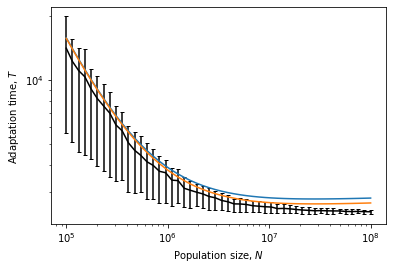

In [21]:
mean = msim_nodirmutN_manu58.mean(axis=1)
low = np.percentile(msim_nodirmutN_manu58, 25, axis=1)
high = np.percentile(msim_nodirmutN_manu58, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2)

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')



plt.xscale('log')
plt.yscale('log')
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$');

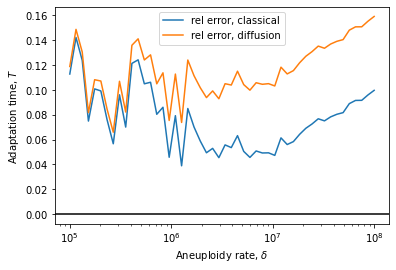

In [10]:
plt.plot(N, (T_-mean)/mean, label='rel error, classical')
plt.plot(N, (T__-mean)/mean, label='rel error, diffusion')
plt.axhline(0,color='k')
plt.xscale('log')

plt.xlabel("Aneuploidy rate, $\delta$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

# Mutation rate on x axis

In [27]:
μm, msim_nodirmutmu = np.load('msim_nodirmutmu.npy',allow_pickle=True)
μm = μm.astype('float64')
assert np.array([x for x in msim_nodirmutmu[1]]).ravel().size == 0 # no direct mutation

msim_nodirmutmu = np.array([x for x in msim_nodirmutmu[0]]) 

In [28]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 5.4e-04, 1, 1.021,1.025, 1.028

In [29]:
T__ = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)

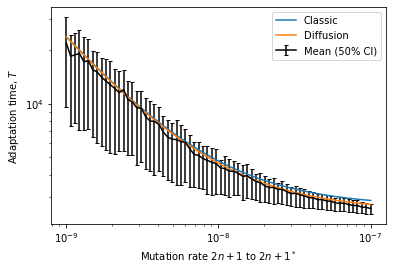

In [14]:
mean = np.mean(msim_nodirmutmu, axis=1)
low = np.percentile(msim_nodirmutmu, 25, axis=1)
high = np.percentile(msim_nodirmutmu, 75, axis=1)
plt.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

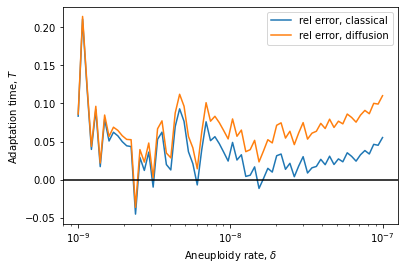

In [15]:
plt.plot(μ, (T_-mean)/mean, label='rel error, classical')
plt.plot(μ, (T__-mean)/mean, label='rel error, diffusion')
plt.axhline(0,color='k')
plt.xscale('log')

plt.xlabel("Aneuploidy rate, $\delta$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

# Aneuploidy rate on x axis

In [16]:
δm, msim_nodirmutde=np.load('msim_nodirmutde.npy',allow_pickle=True)
δm = δm.astype('float64')
assert np.array([x for x in msim_nodirmutde[1]]).ravel().size == 0 # no direct mutation

msim_nodirmutde = np.array([x for x in msim_nodirmutde[0]]) 

In [17]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, 9.6e-08, δm, 1, 1.021, 1.025, 1.028

In [18]:
T__ = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)

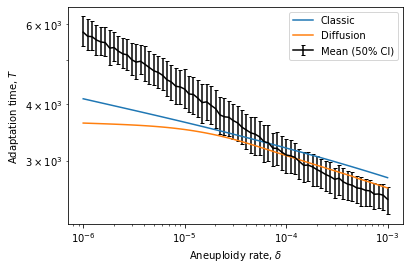

In [19]:
mean = np.mean(msim_nodirmutde, axis=1)
low = np.percentile(msim_nodirmutde, 25, axis=1)
high = np.percentile(msim_nodirmutde, 75, axis=1)
plt.errorbar(δ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(δ, T__, label='Classic')
plt.plot(δ, T_, label='Diffusion')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Aneuploidy rate, $\delta$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

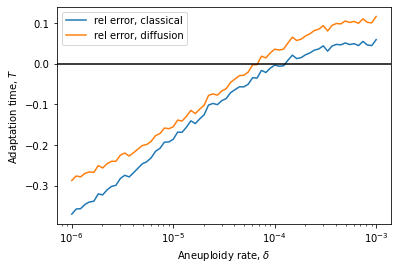

In [20]:
plt.plot(δ,(T_-mean)/mean, label='rel error, classical')
plt.plot(δ,(T__-mean)/mean, label='rel error, diffusion')
plt.axhline(0,color='k')
plt.xscale('log')

plt.xlabel("Aneuploidy rate, $\delta$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

## Gridplots

''

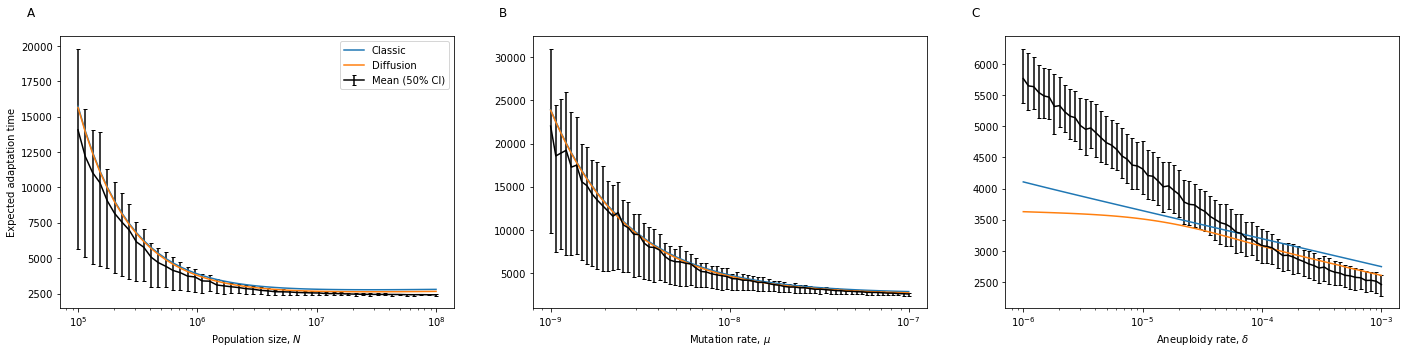

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 5)#, sharey=True
                              )
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 5.4e-04, 1, 1.021, 1.025, 1.028
T__ = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
mean = msim_nodirmutN_manu58.mean(axis=1)
low = np.percentile(msim_nodirmutN_manu58, 25, axis=1)
high = np.percentile(msim_nodirmutN_manu58, 75, axis=1)

ax1.set_title('A',x=-.075,y=1.05)

ax1.set_ylabel('Expected adaptation time')

ax1.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')
ax1.plot(N, T__, label='Classic')
ax1.plot(N, T_, label='Diffusion')

ax1.set_xlabel('Population size, $N$')
ax1.set_xscale('log')
ax1.legend()




N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 5.4e-04, 1, 1.021,1.025, 1.028
T__ = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
mean = np.mean(msim_nodirmutmu, axis=1)
low = np.percentile(msim_nodirmutmu, 25, axis=1)
high = np.percentile(msim_nodirmutmu, 75, axis=1)

ax2.set_title('B',x=-.075,y=1.05)

ax2.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')
ax2.plot(μ, T__, label='Classic')
ax2.plot(μ, T_, label='Diffusion')
ax2.set_xlabel('Mutation rate, $μ$')
#ax2.set_ylim([500,4000])
ax2.set_xscale('log')
#ax2.legend()


N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, 9.6e-08, δm, 1, 1.021, 1.025, 1.028
T__ = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt)
mean = np.mean(msim_nodirmutde, axis=1)
low = np.percentile(msim_nodirmutde, 25, axis=1)
high = np.percentile(msim_nodirmutde, 75, axis=1)

ax3.set_title('C',x=-.075,y=1.05)

ax3.errorbar(δ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

ax3.plot(δ, T__, label='Classic')
ax3.plot(δ, T_, label='Diffusion')
ax3.set_xlabel('Aneuploidy rate, $δ$')
ax3.set_xscale('log')

#fig.savefig('figgrid_noaneu.pdf')
;